In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [14]:
# =================================================================
# 阶段 1: 建立协议数据库 (我们的“配置中心”)
# =================================================================
# 标称容量 (mAh) 和电压 (V)
NOMINAL_CAPACITY = 3000
NOMINAL_VOLTAGE = 3.6

# 定义每个文件的测试协议
# 这是代码通用化的核心
protocols = {
    'VAH01': {'desc': 'Baseline', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH02': {'desc': 'Extended cruise (1000 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH05': {'desc': '10% power reduction', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 10},
    'VAH06': {'desc': 'CC charge current C/2', 'cc_charge_A': 0.5 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH07': {'desc': 'CV charge voltage 4.0V', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.0, 'power_reduction_pct': 0},
    'VAH09': {'desc': 'Temp: 20 deg C', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH10': {'desc': 'Temp: 30 deg C', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH11': {'desc': '20% power reduction', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 20},
    'VAH12': {'desc': 'Short cruise (400 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH13': {'desc': 'Short cruise (600 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH15': {'desc': 'Extended cruise (1000 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH16': {'desc': 'CC charge current 1.5C', 'cc_charge_A': 1.5 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH17': {'desc': 'Baseline', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH20': {'desc': 'CC charge current 1.5C', 'cc_charge_A': 1.5 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH22': {'desc': 'Extended cruise (1000 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH23': {'desc': 'CV charge voltage 4.1V', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.1, 'power_reduction_pct': 0},
    'VAH24': {'desc': 'CC charge current C/2', 'cc_charge_A': 0.5 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH25': {'desc': 'Temp: 20 deg C', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH26': {'desc': 'Short cruise (600 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH27': {'desc': 'Baseline', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH28': {'desc': '10% power reduction', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 10},
    'VAH30': {'desc': 'Temp: 35 deg C', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH06_new': {'desc': 'CC charge current C/2', 'cc_charge_A': 0.5 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH07_new': {'desc': 'CV charge voltage 4.0V', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.0, 'power_reduction_pct': 0},
    'VAH09_new': {'desc': 'Temp: 20 deg C', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH11_new': {'desc': '20% power reduction', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 20},
    'VAH22_new': {'desc': 'Extended cruise (1000 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
}

In [15]:
def process_battery_file(file_path, protocol):
    # --- 修正：日志保存路径 ---
    # 从完整路径中提取文件名，确保日志与脚本在同一目录
    base_filename = os.path.basename(file_path)
    log_filename = base_filename.replace('.csv', '.txt')
    
    with open(log_filename, 'w') as log_file:
        log_file.write(f"--- 分析日志 for: {base_filename} ---\n")
        log_file.write(f"--- 协议: {protocol['desc']} ---\n\n")

        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            log_file.write(f"错误: 文件未找到 {file_path}\n")
            return None, None

        # --- 新增：高级数据清洗模块 (两阶段法) ---
        # 定义毛刺片段的最大长度
        GLITCH_LENGTH_THRESHOLD = 5 

        # 阶段1: 识别所有片段及其长度
        change_indices = np.where(df['Ns'].diff() != 0)[0]
        segment_boundaries = sorted(list(set([0] + change_indices.tolist() + [len(df)])))
        
        segments = []
        for i in range(len(segment_boundaries) - 1):
            start, end = segment_boundaries[i], segment_boundaries[i+1]
            segments.append({
                'ns': df['Ns'].iloc[start],
                'start': start,
                'length': end - start
            })

        # 阶段2: 识别并标记要删除的毛刺序列
        indices_to_drop = []
        i = 1
        while i < len(segments) - 1:
            # 寻找一个短片段序列的开始
            if segments[i]['length'] <= GLITCH_LENGTH_THRESHOLD and segments[i-1]['ns'] == segments[i+1]['ns']:
                # 这是一个潜在的毛刺序列的开始
                glitch_candidate_start_index = i
                
                # 向前看，找到这个短片段序列的结束位置
                j = i
                while j < len(segments) -1 and segments[j]['length'] <= GLITCH_LENGTH_THRESHOLD:
                    j += 1
                
                # 检查这个序列的右边界是否与左边界的Ns值相同
                if segments[i-1]['ns'] == segments[j]['ns']:
                    # 确认这是一个被相同Ns值包围的毛刺序列
                    for k in range(glitch_candidate_start_index, j):
                        start_idx_to_drop = segments[k]['start']
                        end_idx_to_drop = start_idx_to_drop + segments[k]['length']
                        indices_to_drop.extend(range(start_idx_to_drop, end_idx_to_drop))
                    i = j # 从毛刺序列之后继续搜索
                else:
                    i += 1
            else:
                i += 1
        
        if indices_to_drop:
            df.drop(indices_to_drop, inplace=True)
            df.reset_index(drop=True, inplace=True)
            log_file.write(f"[高级数据清洗]: 发现并删除了 {len(indices_to_drop)} 个数据点，这些点属于被识别为毛刺的短序列。\n\n")
        # --- 数据清洗结束 ---

        df['Power_W'] = (df['Ecell_V'] * df['I_mA']) / 1000.0
        # 清洗后重新计算片段边界
        ns_change_indices = df[df['Ns'].diff() != 0].index.tolist()
        segment_boundaries = sorted(list(set([0] + ns_change_indices + [len(df)])))
        
        # [后续核心分析逻辑与之前版本完全相同]
        log_file.write(f"清洗后发现 {len(segment_boundaries) - 1} 个有效片段。\n\n")
        log_file.write(f"{'片段 #':<8} | {'起始时间(s)':<15} | {'持续(s)':<10} | {'状态标签':<35} | {'依据 (I, V, P)'}\n")
        log_file.write("-" * 110 + "\n")
        
        # ... [此部分代码块与上一版本完全相同，为简洁省略] ...
        cc_charge_mA = protocol['cc_charge_A'] * 1000
        cv_voltage_V = protocol['cv_voltage']
        power_factor = (100 - protocol['power_reduction_pct']) / 100.0
        takeoff_power_W = -54 * power_factor
        cruise_power_W = -16 * power_factor
        
        mission_cycle_counter, overall_cycle_counter = 0, 0
        capacity_values, cycle_numbers_for_capacity = [], []
        is_currently_in_rpt, just_exited_rpt = False, False
        current_rpt_max_capacity, is_in_charge_phase = 0, False

        for i in range(len(segment_boundaries) - 1):
            start_idx, end_idx = segment_boundaries[i], segment_boundaries[i+1]
            segment_df = df.iloc[start_idx:end_idx]
            if segment_df.empty: continue
            
            mean_current = segment_df['I_mA'].mean()
            mean_voltage = segment_df['Ecell_V'].mean()
            mean_power = segment_df['Power_W'].mean()
            duration = segment_df['time_s'].iloc[-1] - segment_df['time_s'].iloc[0]

            phase_label, is_this_segment_an_rpt = "未知/过渡", False

            if -700 < mean_current < -500:
                phase_label, is_this_segment_an_rpt = "RPT: C/5 容量测试放电", True
                if 'QDischarge_mA_h' in segment_df.columns:
                    current_rpt_max_capacity = max(current_rpt_max_capacity, segment_df['QDischarge_mA_h'].max())
            elif -100 < mean_current < 100:
                if is_currently_in_rpt and 20 < duration < 40:
                    phase_label, is_this_segment_an_rpt = "RPT: IR测量前静置", True
                else: phase_label = "静置 (Rest)"
            elif mean_current > 100:
                if not is_in_charge_phase:
                    overall_cycle_counter += 1
                    is_in_charge_phase = True
                if mean_voltage > (cv_voltage_V - 0.05): phase_label = "恒压充电 (CV Charge)"
                elif (cc_charge_mA - 200) < mean_current < (cc_charge_mA + 200): phase_label = "恒流充电 (CC Charge)"
                else: phase_label = "其他充电阶段"
            elif mean_current < -100:
                if (takeoff_power_W-5) < mean_power < (takeoff_power_W+5) and 70 < duration < 80:
                    phase_label, mission_cycle_counter = "任务剖面: 起飞 (Take-off)", mission_cycle_counter + 1
                elif (takeoff_power_W-5) < mean_power < (takeoff_power_W+5): phase_label = "任务剖面: 降落 (Landing)"
                elif (cruise_power_W-4) < mean_power < (cruise_power_W+4): phase_label = "任务剖面: 巡航 (Cruise)"
                else: phase_label = "其他放电阶段"
            
            if "充电" not in phase_label: is_in_charge_phase = False
            if not is_this_segment_an_rpt and is_currently_in_rpt: just_exited_rpt = True

            if just_exited_rpt:
                log_file.write("\n" + ">>>" * 15 + " RPT完成 & 验证点 " + "<<<" * 15 + "\n")
                log_file.write(f">>> 在此RPT之前已完成的任务循环次数: {mission_cycle_counter}\n")
                if 48 <= mission_cycle_counter <= 52 or mission_cycle_counter == 0:
                     log_file.write(">>> 结论: 计数符合'每50个循环一次RPT'的规则。\n")
                else:
                     log_file.write(f">>> !!! 警告: 计数 {mission_cycle_counter} 偏离了'50次'的规则。\n")
                
                capacity_values.append(current_rpt_max_capacity)
                cycle_numbers_for_capacity.append(overall_cycle_counter)
                log_file.write(f">>> 数据点记录: Capacity = {current_rpt_max_capacity:.2f} mAh, Cycle Number = {overall_cycle_counter}\n")
                log_file.write(">>>" * 15 + " 验证完成 " + "<<<" * 15 + "\n\n")

                mission_cycle_counter, current_rpt_max_capacity, just_exited_rpt = 0, 0, False
            
            is_currently_in_rpt = is_this_segment_an_rpt
            log_file.write(f"{i+1:<8} | {segment_df['time_s'].iloc[0]:<15.2f} | {duration:<10.2f} | {phase_label:<35} | I={mean_current:7.1f}mA, V={mean_voltage:4.2f}V, P={mean_power:6.2f}W\n")
        
        log_file.write("-" * 110 + "\n--- 分析日志结束 ---\n")
        return cycle_numbers_for_capacity, capacity_values

--- 正在处理: VAH01.csv ---
--- 完成 VAH01.csv。日志和图片已保存。 ---
--- 正在处理: VAH02.csv ---
--- 完成 VAH02.csv。日志和图片已保存。 ---
--- 正在处理: VAH05.csv ---
--- 完成 VAH05.csv。日志和图片已保存。 ---
--- 正在处理: VAH06_new.csv ---
--- 完成 VAH06_new.csv。日志和图片已保存。 ---
--- 正在处理: VAH07_new.csv ---
--- 完成 VAH07_new.csv。日志和图片已保存。 ---
--- 正在处理: VAH09_new.csv ---
--- 完成 VAH09_new.csv。日志和图片已保存。 ---
--- 正在处理: VAH10.csv ---
--- 完成 VAH10.csv。日志和图片已保存。 ---
--- 正在处理: VAH11_new.csv ---
--- 完成 VAH11_new.csv。日志和图片已保存。 ---
--- 正在处理: VAH12.csv ---
--- 完成 VAH12.csv。日志和图片已保存。 ---
--- 正在处理: VAH13.csv ---
--- 完成 VAH13.csv。日志和图片已保存。 ---
--- 正在处理: VAH15.csv ---
--- 完成 VAH15.csv。日志和图片已保存。 ---
--- 正在处理: VAH16.csv ---
--- 完成 VAH16.csv。日志和图片已保存。 ---
--- 正在处理: VAH17.csv ---
--- 完成 VAH17.csv。日志和图片已保存。 ---
--- 正在处理: VAH20.csv ---
--- 完成 VAH20.csv。日志和图片已保存。 ---
--- 正在处理: VAH22_new.csv ---
--- 完成 VAH22_new.csv。日志和图片已保存。 ---
--- 正在处理: VAH23.csv ---
--- 完成 VAH23.csv。日志和图片已保存。 ---
--- 正在处理: VAH24.csv ---
--- 完成 VAH24.csv。日志和图片已保存。 ---
--- 正在处理: VAH25.csv ---
-

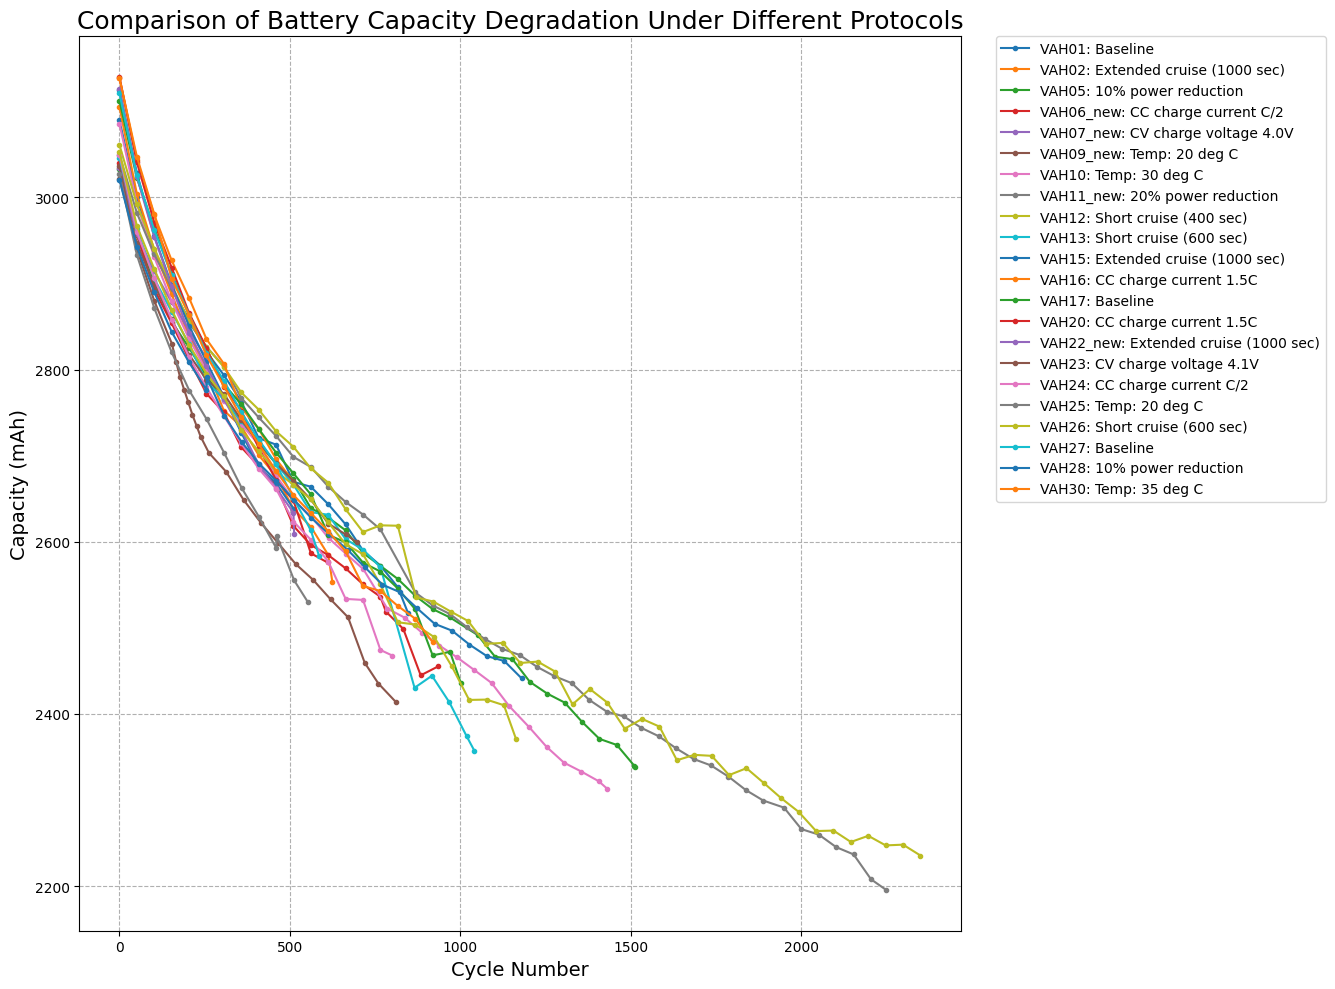

In [16]:
if __name__ == '__main__':
    # 假设CSV文件在一个名为'dataset'的子文件夹中
    # 如果CSV和脚本在同一目录，则设为'.'
    dataset_folder = '../datasets/' 
    all_files = [f for f in os.listdir(dataset_folder) if f.startswith('VAH') and f.endswith('.csv')]
    to_remove = ['VAH06.csv','VAH07.csv','VAH09.csv','VAH11.csv','VAH22.csv']
    for file in to_remove:
        if file in all_files:
            all_files.remove(file)
    
    all_results = {}
    
    for filename in sorted(all_files):
        battery_name = filename.split('.')[0]
        if battery_name in protocols:
            print(f"--- 正在处理: {filename} ---")
            protocol = protocols[battery_name]
            # 传递完整路径给处理函数
            full_path = os.path.join(dataset_folder, filename)
            cycles, capacities = process_battery_file(full_path, protocol)
            
            if cycles and capacities:
                all_results[battery_name] = {'cycles': cycles, 'capacities': capacities, 'desc': protocol['desc']}
                plt.figure(figsize=(10, 6))
                plt.plot(cycles, capacities, 'o-', label=f'{battery_name} Capacity')
                plt.title(f'Capacity Degradation for {battery_name}: {protocol["desc"]}')
                plt.xlabel('Cycle Number')
                plt.ylabel('Capacity (mAh)')
                plt.grid(True)
                plt.savefig(f'{battery_name}_degradation.png')
                plt.close()
                print(f"--- 完成 {filename}。日志和图片已保存。 ---")
            else:
                print(f"--- !!! 未能从 {filename} 提取数据。请检查日志文件。 ---")
        else:
            print(f"--- !!! 警告: 未在协议数据库中找到 {filename} 的配置，已跳过。 ---")

    print("\n--- 所有文件处理完毕。正在生成汇总对比图... ---")
    plt.figure(figsize=(16, 10))
    for battery_name, result in all_results.items():
        plt.plot(result['cycles'], result['capacities'], '.-', label=f"{battery_name}: {result['desc']}")
        
    plt.title('Comparison of Battery Capacity Degradation Under Different Protocols', fontsize=18)
    plt.xlabel('Cycle Number', fontsize=14)
    plt.ylabel('Capacity (mAh)', fontsize=14)
    plt.grid(True, which='both', linestyle='--')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig('SUMMARY_degradation_comparison.png')
    print("--- 汇总图 'SUMMARY_degradation_comparison.png' 已保存。 ---")
    plt.show()